# Install Library

In [1]:
!pip install datasets requests
!pip install tensorflow
!pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 11.7 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.1.5
    Uninstalling typeguard-4.1.5:
      Successfully uninstalled typeguard-4.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which 

# Loading Library

In [2]:
import requests
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

2024-07-30 00:29:16.855547: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-30 00:29:17.161373: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-30 00:29:17.240850: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Loading Data

In [3]:
file_names = [
#     'test_img_data.npy',
#     'test_mask_data.npy',

    'train_img_data.npy',
    'train_mask_data.npy',

    'val_img_data.npy',
    'val_mask_data.npy'
]

In [3]:
# Define the base URL for the dataset files
base_url = "https://huggingface.co/datasets/ismaelvillanuevamiranda/camelyon_preprocessed/resolve/main/"


# Directory to save downloaded files
download_dir = "/kaggle/working/camelyon17"
os.makedirs(download_dir, exist_ok=True)

for file_name in file_names:
    file_url = f"{base_url}{file_name}"
    file_path = os.path.join(download_dir, file_name)
    
    # Download the file
    response = requests.get(file_url)
    if response.status_code == 200:
        with open(file_path, "wb") as file:
            file.write(response.content)
        print(f"Downloaded: {file_name}")
    else:
        print(f"Failed to download: {file_name}")

print("All files have been downloaded.")

Downloaded: train_img_data.npy
Downloaded: train_mask_data.npy
Downloaded: val_img_data.npy
Downloaded: val_mask_data.npy
All files have been downloaded.


In [4]:
# Define file paths
file_paths = {
#     "test_img_data": "/kaggle/working/camelyon17/test_img_data.npy",
#     "test_mask_data": "/kaggle/working/camelyon17/test_mask_data.npy",
    "train_img_data": "/kaggle/working/camelyon17/train_img_data.npy",
    "train_mask_data": "/kaggle/working/camelyon17/train_mask_data.npy",
    "val_img_data": "/kaggle/working/camelyon17/val_img_data.npy",
    "val_mask_data": "/kaggle/working/camelyon17/val_mask_data.npy"
}

# Load the data
data = {name: np.load(path) for name, path in file_paths.items()}

# Print shapes of the loaded data
for name, array in data.items():
    print(f"{name}: shape = {array.shape}")

train_img_data: shape = (1036, 512, 512, 3)
train_mask_data: shape = (1036, 512, 512)
val_img_data: shape = (733, 512, 512, 3)
val_mask_data: shape = (733, 512, 512)


# Processing In Data

In [5]:
# Extract images and masks
x_train = data["train_img_data"]
y_train = data["train_mask_data"]
x_val = data["val_img_data"]
y_val = data["val_mask_data"]
# x_test = data["test_img_data"]
# y_test = data["test_mask_data"]

# Normalize images
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
# x_test = x_test.astype('float32') / 255.0

# Ensure masks are in binary format
y_train = (y_train > 0.5).astype('float32')
y_val = (y_val > 0.5).astype('float32')
# y_test = (y_test > 0.5).astype('float32')

y_train = np.expand_dims(y_train, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)
# y_test = np.expand_dims(y_test, axis=-1)

# Check shapes
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")
# print(f"x_val shape: {x_test.shape}")
# print(f"y_val shape: {y_test.shape}")

x_train shape: (1036, 512, 512, 3)
y_train shape: (1036, 512, 512, 1)
x_val shape: (733, 512, 512, 3)
y_val shape: (733, 512, 512, 1)


In [6]:
def merge_history(hlist):
    history = {}
    for k in hlist[0].history.keys():
        history[k] = sum([h.history[k] for h in hlist], [])
    return history

def vis_training(h, start=1):
    epoch_range = range(start, len(h['loss'])+1)
    s = slice(start-1, None)

    plt.figure(figsize=[14,4])

    n = int(len(h.keys()) / 2)

    for i in range(n):
        k = list(h.keys())[i]
        plt.subplot(1,n,i+1)
        plt.plot(epoch_range, h[k][s], label='Training')
        plt.plot(epoch_range, h['val_' + k][s], label='Validation')
        plt.xlabel('Epoch'); plt.ylabel(k); plt.title(k)
        plt.grid()
        plt.legend()

    plt.tight_layout()
    plt.show()

# Show Some Image

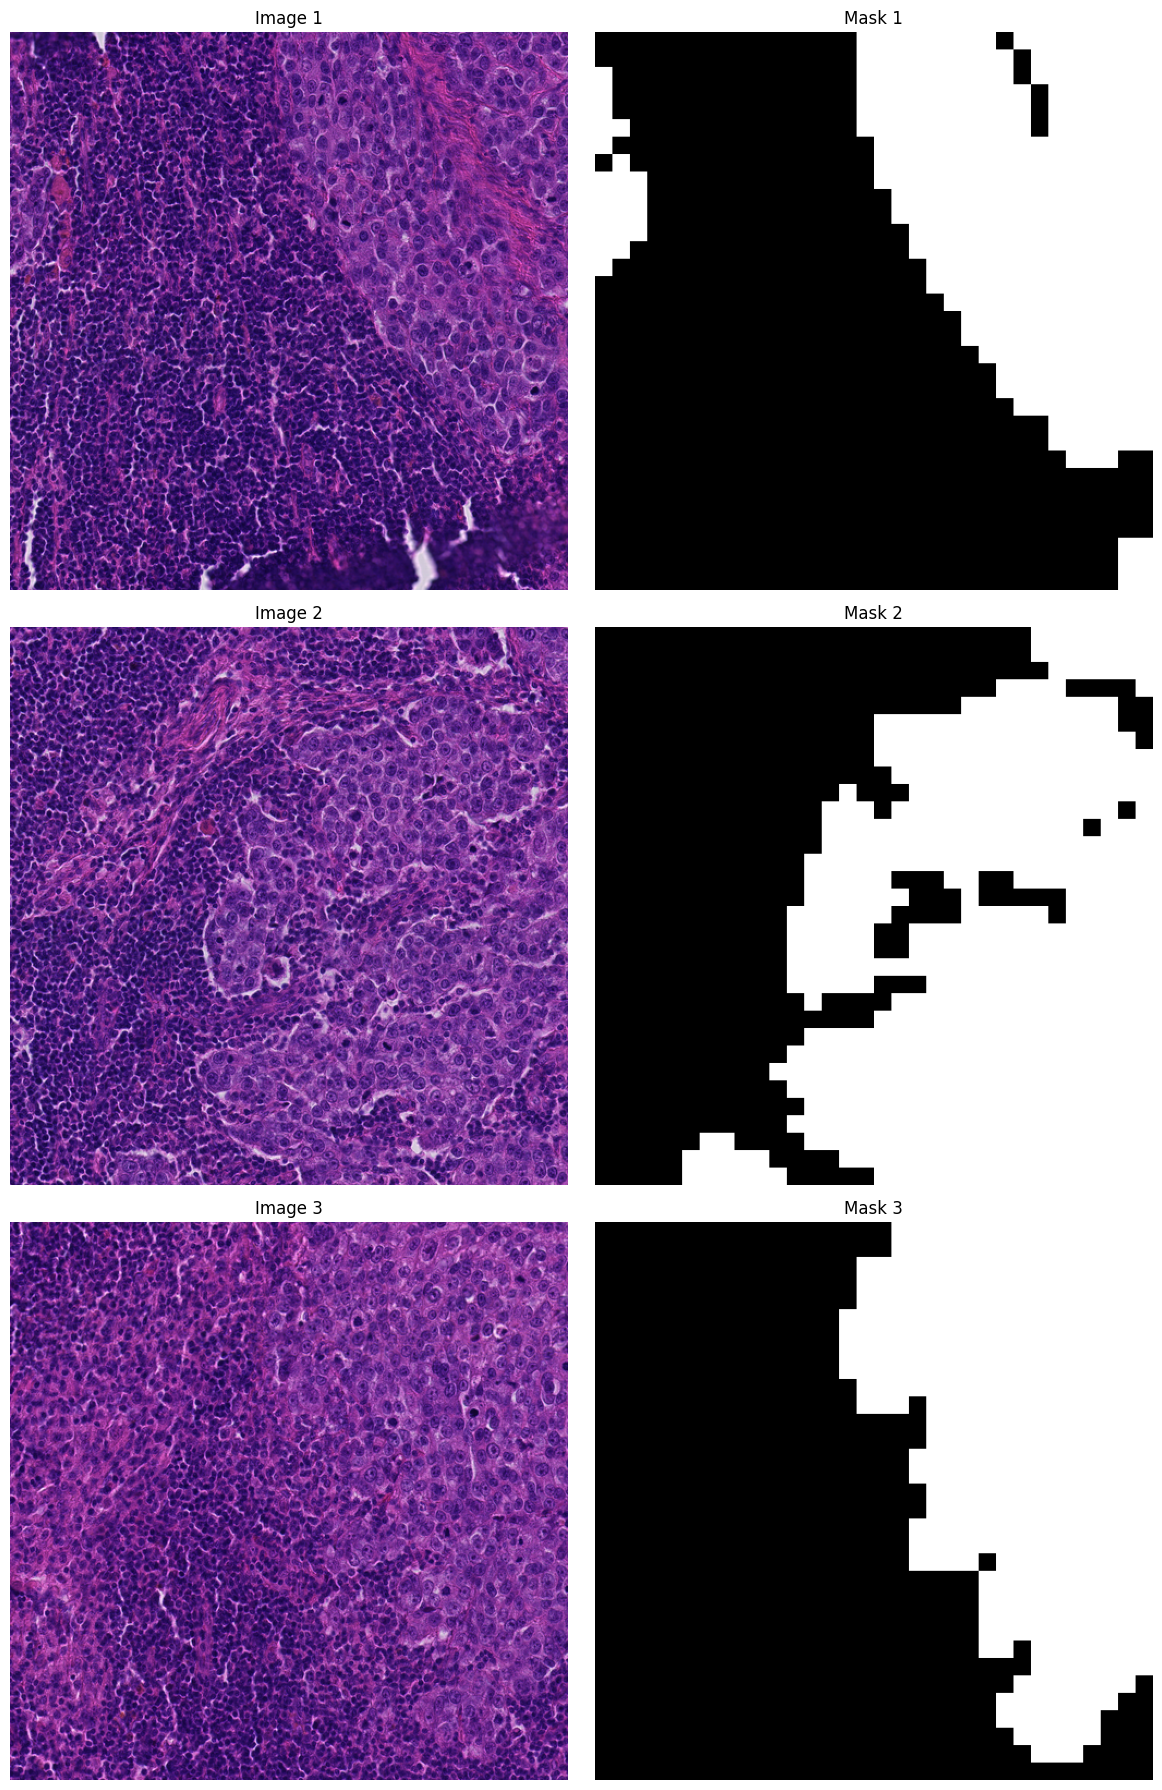

In [7]:
import matplotlib.pyplot as plt

def display_images(images, masks, num_samples=3):
    """Display images and their corresponding masks."""
    fig, axes = plt.subplots(num_samples, 2, figsize=(12, 6 * num_samples))
    for i in range(num_samples):
        axes[i, 0].imshow(images[500-i], cmap='gray')
        axes[i, 0].set_title(f"Image {i + 1}")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(masks[500-i], cmap='gray')
        axes[i, 1].set_title(f"Mask {i + 1}")
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Display samples from the test set
test_images = data["train_img_data"]
test_masks = data["train_mask_data"]

display_images(test_images, test_masks)

# Building Model

## Model_1 - Unet Model

In [6]:
def unet_model(input_shape):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

In [7]:
# Define input shape
input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])

# Create U-Net model
model = unet_model(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'mse'])

In [8]:
# Train the model
history = model.fit(x_train, y_train, 
                    epochs=10,
                    batch_size=2,
                    validation_data=(x_val, y_val))

Epoch 1/10


2024-07-29 23:15:42.267749: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.96943, expected 4.13831
2024-07-29 23:15:42.267803: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 6.82185, expected 5.99072
2024-07-29 23:15:42.267821: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 6.62315, expected 5.79201
2024-07-29 23:15:42.267838: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.80174, expected 5.97062
2024-07-29 23:15:42.267850: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.5794, expected 4.74827
2024-07-29 23:15:42.267862: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 7.04486, expected 6.21373
2024-07-29 23:15:42.267873: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.86165, expected 6.03052
2024-07-29 23:15:42.267883: E external/local_xla/xla/ser

518/518 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.5574 - loss: 7.0176 - mse: 0.4428

2024-07-29 23:18:28.592819: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 146: 3.2398, expected 2.80361
2024-07-29 23:18:28.593946: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 208895: 3.14388, expected 2.7077
2024-07-29 23:18:28.594265: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 262144: 4.01226, expected 3.2662
2024-07-29 23:18:28.594287: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 262145: 5.99268, expected 5.24662
2024-07-29 23:18:28.594295: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 262146: 4.79158, expected 4.04552
2024-07-29 23:18:28.594303: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 262147: 5.89458, expected 5.14853
2024-07-29 23:18:28.594311: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 262148: 4.22839, expected 3.48233
2024-07-29 23:18:28.594319

518/518 ━━━━━━━━━━━━━━━━━━━━ 183s 268ms/step - accuracy: 0.5574 - loss: 7.0181 - mse: 0.4428 - val_accuracy: 0.5301 - val_loss: 7.5734 - val_mse: 0.4699
Epoch 2/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 121s 234ms/step - accuracy: 0.5405 - loss: 7.4064 - mse: 0.4595 - val_accuracy: 0.5301 - val_loss: 7.5734 - val_mse: 0.4699
Epoch 3/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 122s 235ms/step - accuracy: 0.5475 - loss: 7.2936 - mse: 0.4525 - val_accuracy: 0.5301 - val_loss: 7.5734 - val_mse: 0.4699
Epoch 4/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 122s 235ms/step - accuracy: 0.5411 - loss: 7.3971 - mse: 0.4589 - val_accuracy: 0.5301 - val_loss: 7.5734 - val_mse: 0.4699
Epoch 5/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 122s 235ms/step - accuracy: 0.5463 - loss: 7.3120 - mse: 0.4537 - val_accuracy: 0.5301 - val_loss: 7.5734 - val_mse: 0.4699
Epoch 6/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 122s 235ms/step - accuracy: 0.5310 - loss: 7.5593 - mse: 0.4690 - val_accuracy: 0.5301 - val_loss: 7.5734 - val_mse: 0.4699
Epoch 7/10
518/518 ━━━━━━━━

In [ ]:
# Save the model if needed
model.save('/kaggle/working/unet_model.h5')

# DeeplabV3 Model

In [9]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

def deeplabv3_plus(input_shape):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False)
    base_model_output = base_model.get_layer('block_13_expand_relu').output
    
    # Atrous Spatial Pyramid Pooling
    b4 = tf.keras.layers.GlobalAveragePooling2D()(base_model_output)
    b4 = tf.keras.layers.Reshape((1, 1, b4.shape[1]))(b4)
    b4 = tf.keras.layers.Conv2D(256, 1, padding='same', use_bias=False)(b4)
    b4 = tf.keras.layers.BatchNormalization()(b4)
    b4 = tf.keras.layers.ReLU()(b4)
    b4 = tf.keras.layers.UpSampling2D(size=(base_model_output.shape[1], base_model_output.shape[2]), interpolation='bilinear')(b4)

    b0 = tf.keras.layers.Conv2D(256, 1, padding='same', use_bias=False)(base_model_output)
    b0 = tf.keras.layers.BatchNormalization()(b0)
    b0 = tf.keras.layers.ReLU()(b0)

    b1 = tf.keras.layers.DepthwiseConv2D(3, dilation_rate=1, padding='same', use_bias=False)(base_model_output)
    b1 = tf.keras.layers.BatchNormalization()(b1)
    b1 = tf.keras.layers.ReLU()(b1)
    b1 = tf.keras.layers.Conv2D(256, 1, padding='same', use_bias=False)(b1)
    b1 = tf.keras.layers.BatchNormalization()(b1)
    b1 = tf.keras.layers.ReLU()(b1)

    b2 = tf.keras.layers.DepthwiseConv2D(3, dilation_rate=2, padding='same', use_bias=False)(base_model_output)
    b2 = tf.keras.layers.BatchNormalization()(b2)
    b2 = tf.keras.layers.ReLU()(b2)
    b2 = tf.keras.layers.Conv2D(256, 1, padding='same', use_bias=False)(b2)
    b2 = tf.keras.layers.BatchNormalization()(b2)
    b2 = tf.keras.layers.ReLU()(b2)

    b3 = tf.keras.layers.DepthwiseConv2D(3, dilation_rate=3, padding='same', use_bias=False)(base_model_output)
    b3 = tf.keras.layers.BatchNormalization()(b3)
    b3 = tf.keras.layers.ReLU()(b3)
    b3 = tf.keras.layers.Conv2D(256, 1, padding='same', use_bias=False)(b3)
    b3 = tf.keras.layers.BatchNormalization()(b3)
    b3 = tf.keras.layers.ReLU()(b3)

    x = Concatenate()([b4, b0, b1, b2, b3])
    x = tf.keras.layers.Conv2D(256, 1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = UpSampling2D(size=(4, 4), interpolation='bilinear')(x)

    input_a = base_model.get_layer('block_3_expand_relu').output
    input_a = tf.keras.layers.Conv2D(48, 1, padding='same', use_bias=False)(input_a)
    input_a = tf.keras.layers.BatchNormalization()(input_a)
    input_a = tf.keras.layers.ReLU()(input_a)

    x = Concatenate()([x, input_a])
    x = tf.keras.layers.Conv2D(256, 3, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(256, 3, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = UpSampling2D(size=(4, 4), interpolation='bilinear')(x)
    x = tf.keras.layers.Conv2D(1, 1, padding='same', activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=x)
    return model


In [10]:
# Define input shape
input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])

# Create the model
model_2 = deeplabv3_plus(input_shape)

# Compile the model
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/tmp/ipykernel_34/1529705746.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=input_shape, include_top=False)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
# Train the model
history_2 = model_2.fit(x_train, y_train, 
                    epochs=10, 
                    batch_size=2, 
                    validation_data=(x_val, y_val))

Epoch 1/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 136s 165ms/step - accuracy: 0.7165 - loss: 0.6247 - val_accuracy: 0.4518 - val_loss: 0.7656
Epoch 2/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 70s 136ms/step - accuracy: 0.7595 - loss: 0.5148 - val_accuracy: 0.5307 - val_loss: 3.6302
Epoch 3/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 71s 137ms/step - accuracy: 0.8005 - loss: 0.4540 - val_accuracy: 0.6073 - val_loss: 0.8653
Epoch 4/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 70s 135ms/step - accuracy: 0.8430 - loss: 0.3837 - val_accuracy: 0.4833 - val_loss: 1.5054
Epoch 5/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 70s 135ms/step - accuracy: 0.8421 - loss: 0.3725 - val_accuracy: 0.6899 - val_loss: 0.5591
Epoch 6/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 70s 135ms/step - accuracy: 0.8750 - loss: 0.3250 - val_accuracy: 0.6740 - val_loss: 0.8078
Epoch 7/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 70s 135ms/step - accuracy: 0.8694 - loss: 0.3302 - val_accuracy: 0.8166 - val_loss: 0.4119
Epoch 8/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 70s 134ms/step - accuracy: 0.8846 - loss: 

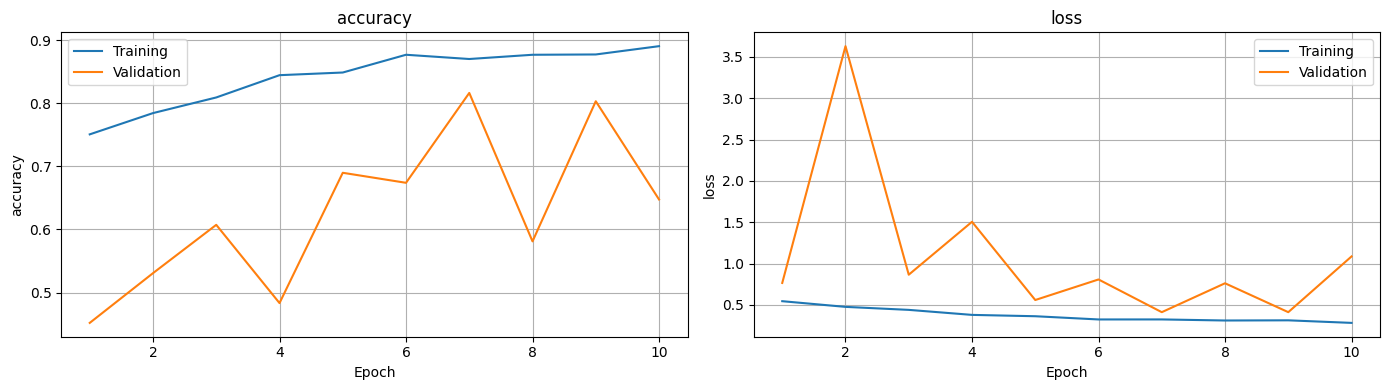

In [15]:
history_modeldeeplab = merge_history([history])
vis_training(history_modeldeeplab)

# Model3

In [7]:
!pip install -U --pre segmentation-models
!pip install --upgrade tensorflow segmentation-models

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [8]:
import os

os.environ["SM_FRAMEWORK"] = "tf.keras"
# sm.set_framework('tf.keras')

In [9]:
import segmentation_models as sm
from tensorflow import keras
import segmentation_models as sm
from segmentation_models import Unet

Segmentation Models: using `tf.keras` framework.


In [10]:
# Define the model
BACKBONE = 'efficientnetb0'
model_3 = Unet(BACKBONE, encoder_weights='imagenet', input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))

I0000 00:00:1722299535.550677     325 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1722299535.691778     325 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1722299535.692067     325 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1722299535.696967     325 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [11]:

# Compile the model
model_3.compile(optimizer='adam', loss='mse', metrics=['accuracy', tf.metrics.Precision(), tf.metrics.Recall()])

In [12]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs:
            loss = logs.get('loss', 'N/A')
            iou_score = logs.get('iou_score', 'N/A')
            val_loss = logs.get('val_loss', 'N/A')
            val_iou_score = logs.get('val_iou_score', 'N/A')
            print(f"Epoch {epoch+1}: Loss = {loss}, IoU Score = {iou_score}, Val Loss = {val_loss}, Val IoU Score = {val_iou_score}")
        else:
            print(f"Epoch {epoch+1}: No logs available")

# Train the model
history_3 = model_3.fit(
    x_train, y_train,
    epochs=10,
    batch_size=2,
    validation_data=(x_val, y_val),
    callbacks=[CustomCallback()]
)

Epoch 1/10


I0000 00:00:1722299620.389899     410 service.cc:146] XLA service 0x7c06ec003ef0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722299620.389951     410 service.cc:154]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
E0000 00:00:1722299633.350206     410 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1722299633.607824     410 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1722299638.454650     410 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1722299638.647821     410 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-opti

  1/518 ━━━━━━━━━━━━━━━━━━━━ 11:40:28 81s/step - accuracy: 0.3948 - loss: 0.3427 - precision: 0.0000e+00 - recall: 0.0000e+00

I0000 00:00:1722299664.082225     410 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


518/518 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7047 - loss: 0.2006 - precision: 0.6775 - recall: 0.6746Epoch 1: Loss = 0.18665972352027893, IoU Score = N/A, Val Loss = 0.08271727710962296, Val IoU Score = N/A
518/518 ━━━━━━━━━━━━━━━━━━━━ 153s 139ms/step - accuracy: 0.7048 - loss: 0.2006 - precision: 0.6775 - recall: 0.6747 - val_accuracy: 0.8986 - val_loss: 0.0827 - val_precision: 0.8611 - val_recall: 0.9349
Epoch 2/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7953 - loss: 0.1538 - precision: 0.7493 - recall: 0.7977Epoch 2: Loss = 0.15116138756275177, IoU Score = N/A, Val Loss = 0.11519929766654968, Val IoU Score = N/A
518/518 ━━━━━━━━━━━━━━━━━━━━ 53s 102ms/step - accuracy: 0.7953 - loss: 0.1538 - precision: 0.7493 - recall: 0.7977 - val_accuracy: 0.8443 - val_loss: 0.1152 - val_precision: 0.9468 - val_recall: 0.7084
Epoch 3/10
518/518 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8396 - loss: 0.1262 - precision: 0.8057 - recall: 0.8211Epoch 3: Loss = 0.1346575

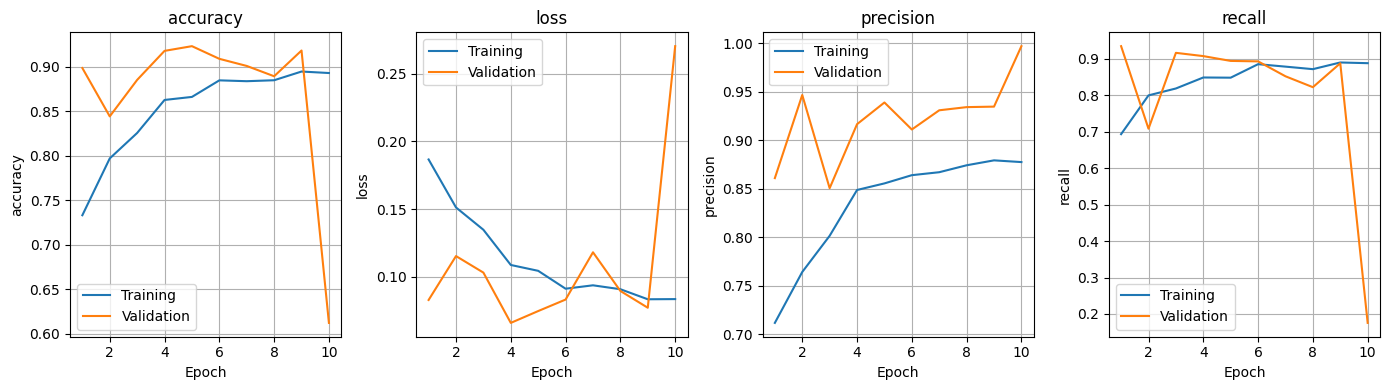

In [13]:
history_model_efficientnetb0 = merge_history([history_3])
vis_training(history_model_efficientnetb0)

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 85.3 MB/s eta 0:00:00:00:01
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.5.26
    Uninstalling flatbuffers-23.5.26:
      Successfully uninstalled flatbuffers-23.5.26
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.1
    Uninstalling tensorboard-2.15.1:
      Successfully uninstalled tensorboard-2.15.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0
ERROR: pip's dependency resolver does not currently take into